In [4]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

In [67]:
plt.style.use("ggplot")

* How many different cases are there, by department?

In [25]:
# case number by department
df.groupby("department").agg(count('case_id')).show()

+--------------------+--------------+
|          department|count(case_id)|
+--------------------+--------------+
|         Solid Waste|        279270|
|Animal Care Services|        116915|
|Trans & Cap Impro...|         96193|
|  Parks & Recreation|         19907|
|    Customer Service|          2849|
|        Metro Health|          5163|
|        City Council|            33|
|DSD/Code Enforcement|        321374|
+--------------------+--------------+



<AxesSubplot:ylabel='department'>

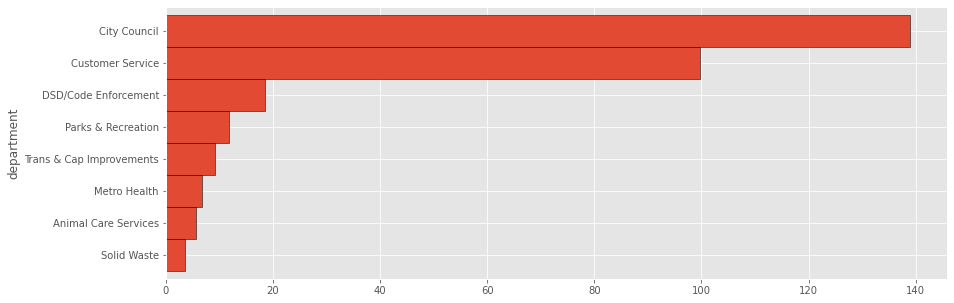

In [68]:
# Explore by case lifetime by dept to see who's more efficient
(
df.groupby("department").agg(mean('case_lifetime').alias('case_life'))
.toPandas()
.set_index('department')
.case_life.sort_values(ascending=True)
.plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)


* Does the percentage of cases that are late vary by department?


In [36]:
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean')]

Text(0.5, 1.0, 'Perc Late By Department')

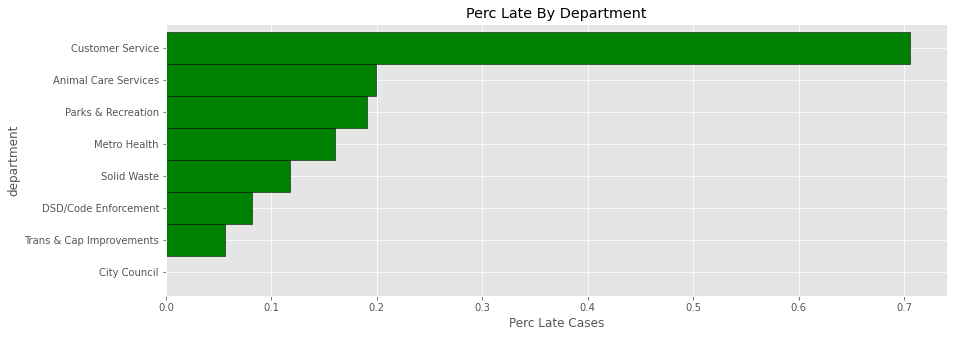

In [69]:
(   
    df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("perc_case_late"))
    .toPandas()
    .set_index("department")
    .perc_case_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Perc Late Cases")
plt.title("Perc Late By Department")

* Does the number of service requests for the solid waste department vary by day of the week?

In [39]:
df_sw = (
    df
    .filter(df.department == "Solid Waste")
)

In [42]:
df_sw.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127378           
 case_opened_date     | 2018-01-01 08:24:00  
 case_closed_date     | 2018-01-02 07:37:00  
 case_due_date        | 2018-01-03 08:24:00  
 case_late            | false                
 num_days_late        | -1.03287037          
 case_closed          | true                 
 service_request_type | Dead Animal - Cat    
 SLA_days             | 2.0                  
 case_status          | Closed               
 source_id            | 139344               
 request_address      | 7059  TIMBERCREEK... 
 council_district     | 006                  
 num_weeks_late       | -0.14755290999999998 
 zipcode              | 78227                
 case_age             | 219                  
 days_to_closed       | 1                    
 case_lifetime        | 1                    
 department           | Solid Waste          
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [64]:
req_daily = df_sw.select(
    "department",
    "case_id",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    dayofweek("case_opened_date").alias('day')
)

req_daily.show(5)

+-----------+----------+----------------+---+
| department|   case_id|case_opened_date|day|
+-----------+----------+----------------+---+
|Solid Waste|1014127378|      2018-01-01|  2|
|Solid Waste|1014127411|      2018-01-01|  2|
|Solid Waste|1014127439|      2018-01-01|  2|
|Solid Waste|1014127442|      2018-01-01|  2|
|Solid Waste|1014127445|      2018-01-01|  2|
+-----------+----------+----------------+---+
only showing top 5 rows



In [65]:
cases_opened_by_day = (
    req_daily
    .groupby('day')
    .count()
    .na.drop()
    .sort('day')
    .toPandas()
    .set_index('day'))['count']

In [72]:
cases_opened_by_day

day
1     6885
2    58085
3    58120
4    41947
5    47718
6    51203
7    15312
Name: count, dtype: int64

Text(0.5, 1.0, 'Solid Waste Cases Opened by Day')

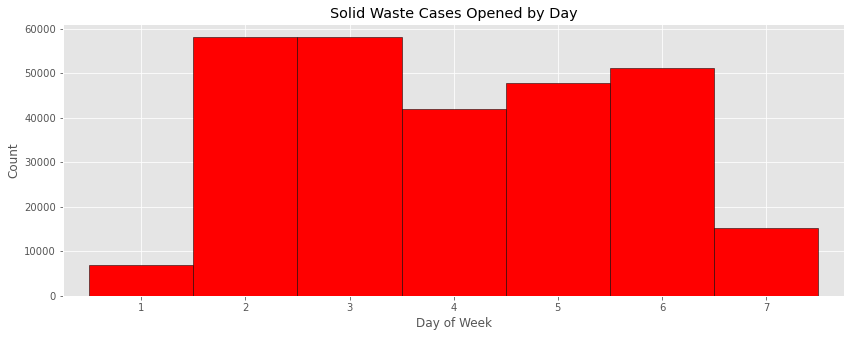

In [79]:
cases_opened_by_day.plot.bar(width=1, edgecolor="black", figsize=(14, 5), color='red')
plt.xlabel("Day of Week")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Solid Waste Cases Opened by Day")